In [3]:
!pip install networkx pandas numpy matplotlib nltk gensim pyvis wordcloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 80.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the fo

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyvis.network import Network
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim import corpora, models
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!wget -q http://snap.stanford.edu/data/twitter_combined.txt.gz
!gunzip -f twitter_combined.txt.gz

In [28]:
edges = pd.read_csv('twitter_combined.txt', sep=' ', header=None, names=['source','target'])

In [29]:
G = nx.from_pandas_edgelist(edges, 'source', 'target', create_using=nx.DiGraph())
print(f"Graph loaded: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

Graph loaded: 81306 nodes, 1768149 edges


In [30]:
degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G, k=100, seed=42)  # approximate for speed
pagerank = nx.pagerank(G, alpha=0.85)

In [37]:
pagerank_str = { str(uid): score
                 for uid, score in pagerank.items() }


In [38]:
centrality_df = pd.DataFrame({
    'user_id': list(degree_cent.keys()),
    'degree_centrality': list(degree_cent.values()),
    'betweenness_centrality': list(betweenness_cent.values()),
    'pagerank': list(pagerank.values())
})
centrality_df.sort_values('pagerank', ascending=False, inplace=True)

In [33]:
edges[['source','target']] = edges[['source','target']].astype(str)
centrality_df['user_id']    = centrality_df['user_id'].astype(str)

In [39]:
# Display top 10 influencers by PageRank
print("Top 10 influencers by PageRank:")
print(centrality_df.head(10))

Top 10 influencers by PageRank:
        user_id  degree_centrality  betweenness_centrality  pagerank
1758  115485051           0.041621                0.000010  0.004331
8224  116485573           0.000061                0.000000  0.004133
1550     813286           0.046221                0.141731  0.002339
63     40981798           0.041018                0.018639  0.001372
436     7861312           0.028264                0.011774  0.001254
818    11348282           0.023111                0.008771  0.001222
2413   17093617           0.023037                0.066802  0.001076
501    15439395           0.017736                0.036121  0.001031
3506   18396070           0.003813                0.000507  0.001029
3755   14230524           0.015694                0.023682  0.001014


In [35]:
net = Network(height='600px', width='100%', directed=True)

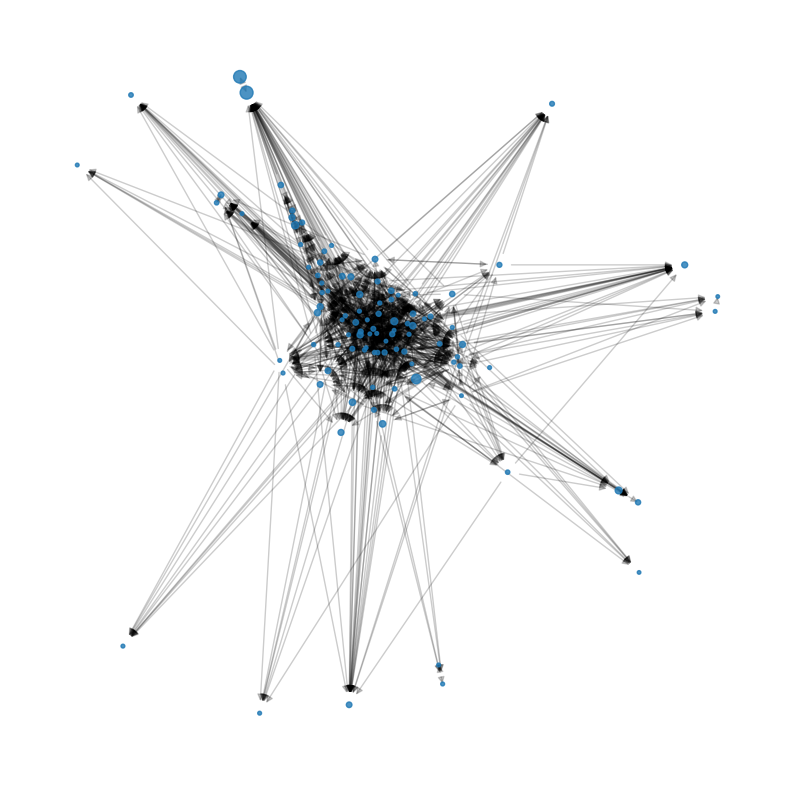

In [54]:
import matplotlib.pyplot as plt
import networkx as nx

# create the subgraph of top‐100 nodes (make sure these are ints again)
top_ints = [int(n) for n in top_nodes]
subG = G.subgraph(top_ints)

# compute positions
pos = nx.spring_layout(subG, seed=42)

# draw
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(subG, pos,
                       node_size=[pagerank[i]*20000 for i in subG.nodes()],
                       alpha=0.8)
nx.draw_networkx_edges(subG, pos, alpha=0.2)
plt.axis('off')
plt.show()


In [51]:
G.remove_edges_from(nx.selfloop_edges(G))

In [52]:
from networkx.algorithms import clustering, core_number
in_deg = dict(G.in_degree())
out_deg = dict(G.out_degree())
cluster_coef = clustering(G.to_undirected())
core_num = core_number(G.to_undirected())

features = pd.DataFrame({
    'user_id': list(in_deg.keys()),
    'in_degree': list(in_deg.values()),
    'out_degree': list(out_deg.values()),
    'clustering_coeff': [cluster_coef[u] for u in in_deg.keys()],
    'core_number': [core_num[u] for u in in_deg.keys()]
})

analysis_df = centrality_df.merge(features, on='user_id')

In [53]:
print(f"Loaded network with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges (self-loops removed).")


Loaded network with 81306 nodes and 1768135 edges (self-loops removed).


In [55]:
analysis_df = centrality_df.merge(features, on='user_id')


In [57]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim import corpora, models
from wordcloud import WordCloud
# Download NLTK resources
nltk.download('punkt')
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [59]:
import seaborn as sns


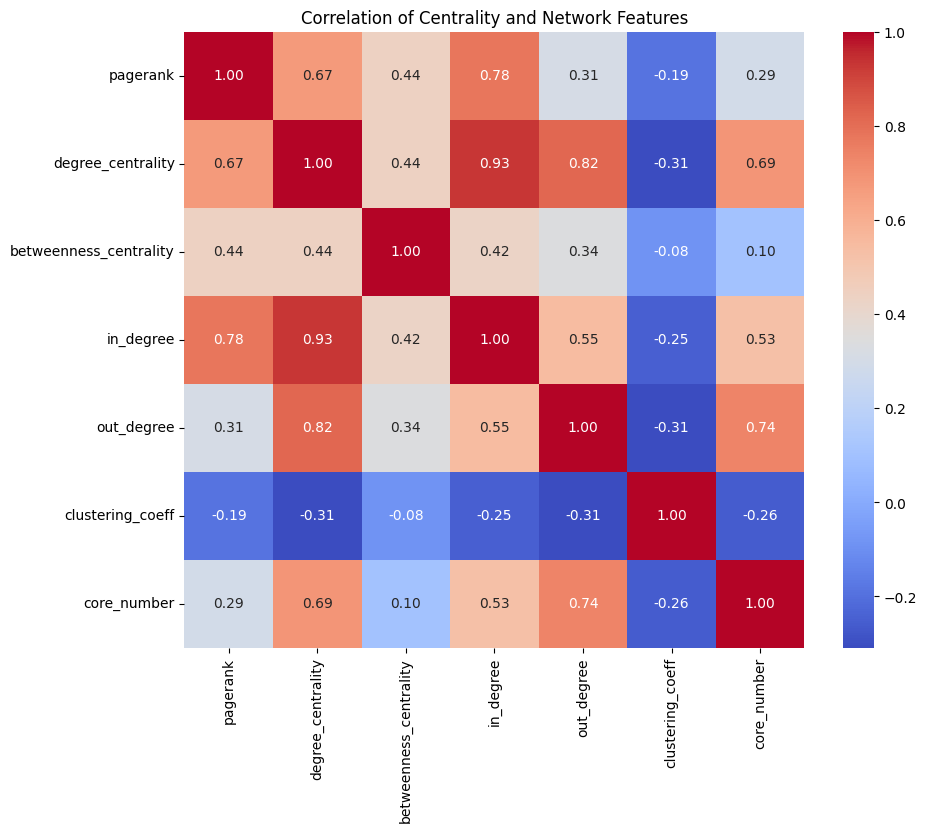

In [60]:
corr = analysis_df[['pagerank','degree_centrality','betweenness_centrality',
                   'in_degree','out_degree','clustering_coeff','core_number']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation of Centrality and Network Features')
plt.show()

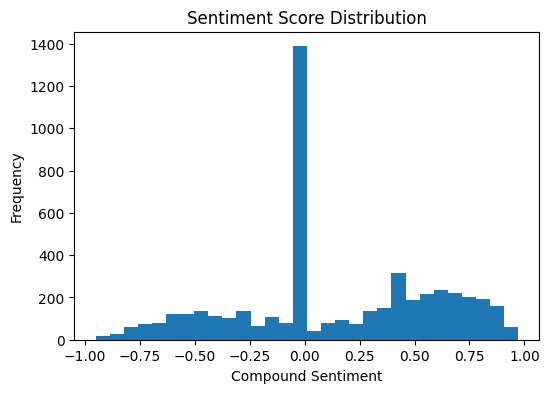

In [61]:
# Example: download sample tweets from Sentiment140
!wget -q http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip -q trainingandtestdata.zip
# File 'training.1600000.processed.noemoticon.csv' contains tweets
cols = ['target','ids','date','flag','user','text']
tweets = pd.read_csv('training.1600000.processed.noemoticon.csv',
                     encoding='latin-1', names=cols)
# Sample for performance
tweets_sample = tweets.sample(5000, random_state=42)

# Sentiment analysis
sia = SentimentIntensityAnalyzer()
tweets_sample['sentiment'] = tweets_sample['text'].apply(
    lambda t: sia.polarity_scores(str(t))['compound']
)
plt.figure(figsize=(6,4))
plt.hist(tweets_sample['sentiment'], bins=30)
plt.title('Sentiment Score Distribution')
plt.xlabel('Compound Sentiment')
plt.ylabel('Frequency')
plt.show()

In [63]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [64]:
texts = [[w.lower() for w in nltk.word_tokenize(t)] for t in tweets_sample['text']]
dict_ = corpora.Dictionary(texts)
corpus = [dict_.doc2bow(text) for text in texts]
lda = models.LdaModel(corpus, num_topics=5, id2word=dict_, passes=5)
for i, topic in lda.print_topics():
    print(f"Topic {i}: {topic}")


Topic 0: 0.036*"i" + 0.028*"my" + 0.028*"to" + 0.022*"@" + 0.020*"the" + 0.016*"," + 0.014*"." + 0.012*"a" + 0.012*"!" + 0.012*"..."
Topic 1: 0.046*"@" + 0.040*"." + 0.016*"you" + 0.014*"the" + 0.010*"?" + 0.009*"my" + 0.009*"is" + 0.009*"for" + 0.008*"to" + 0.007*"me"
Topic 2: 0.048*"!" + 0.038*"i" + 0.032*"to" + 0.028*"." + 0.021*"," + 0.020*"a" + 0.018*"the" + 0.017*"@" + 0.013*"you" + 0.011*"it"
Topic 3: 0.050*";" + 0.044*"&" + 0.025*"@" + 0.023*"quot" + 0.019*"!" + 0.018*"," + 0.017*"i" + 0.013*"amp" + 0.010*":" + 0.009*"."
Topic 4: 0.041*"." + 0.039*"@" + 0.036*"i" + 0.030*"!" + 0.018*"the" + 0.017*"," + 0.014*"it" + 0.012*"you" + 0.012*"a" + 0.011*"and"


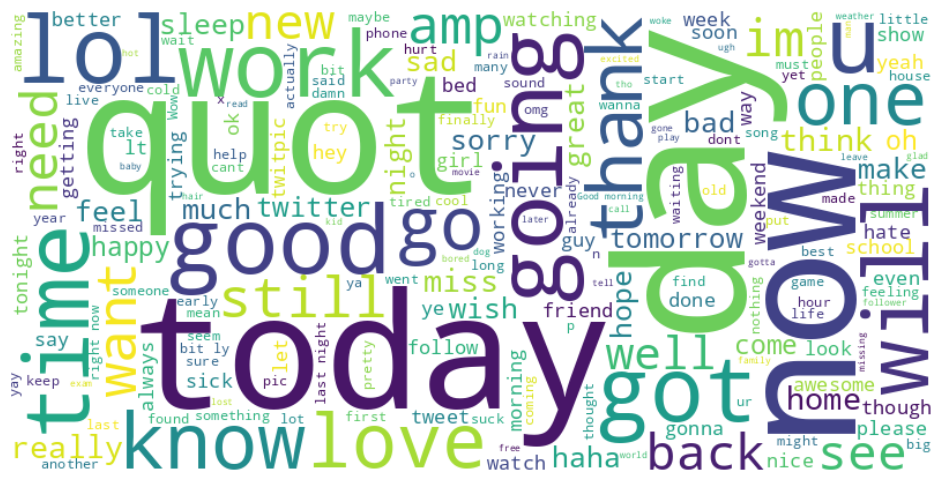

In [66]:
all_text = ' '.join(tweets_sample['text'].astype(str).tolist())
wc = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()
